# RNA velocity

Using scvelo.

# 0. Loading the libraries

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import scvelo as scv

import multiprocessing
multiprocessing.cpu_count()

import cellrank as cr
import warnings

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [2]:
# Set up constants
save_folder = "figures/"
objects_folder = "saved_objects/"
sc.settings.figdir = './'+save_folder

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3

# 1. Both

In [3]:
with open('saved_objects/adata_annotated.pkl', 'rb') as inp:
    adata = pickle.load(inp)

saving figure to file ./figures/scvelo_proportions_splice_props.png


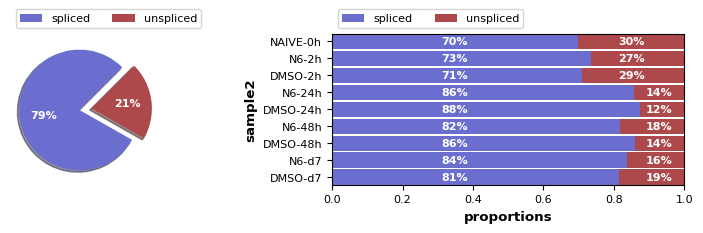

In [8]:
scv.pl.proportions(adata, groupby="sample2", save="splice_props.png")

# 2. DMSO

In [4]:
COND = 'DMSO'
OTHER_COND = 'N6'

In [5]:
with open('saved_objects/adata_annotated.pkl', 'rb') as inp:
    adata = pickle.load(inp)

adata = adata[adata.obs.cond != OTHER_COND]

In [6]:
sc.tl.pca(adata, random_state=0)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:12)
computing neighbors
    using 'X_pca' with n_pcs = 30


2022-06-24 13:47:54.077031: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/lib/R/lib:
2022-06-24 13:47:54.077139: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:46)
Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:30) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [7]:
scv.tl.recover_dynamics(adata, n_top_genes = 4000, n_jobs=40)

recovering dynamics (using 40/40 cores)


  0%|          | 0/2143 [00:00<?, ?gene/s]

    finished (0:10:43) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [8]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:1000]
scv.tl.differential_kinetic_test(adata, var_names=top_genes, groupby='tp')

testing for differential kinetics
    finished (0:12:23) --> added 
    'fit_diff_kinetics', clusters displaying differential kinetics (adata.var)
    'fit_pvals_kinetics', p-values of differential kinetics (adata.var)


In [9]:
scv.tl.velocity(adata, mode = "dynamical", groupby="tp", diff_kinetics=True)
scv.tl.velocity_graph(adata, n_jobs=40)

computing velocities
    finished (0:01:53) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 40/40 cores)


  0%|          | 0/18064 [00:00<?, ?cells/s]

    finished (0:01:53) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [10]:
save_object(adata, "saved_objects/velocity"+"_"+COND+".pkl")

In [22]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color=["tp", "Il10_positive"], legend_loc = "right margin", 
                                show=False, save="embed_umap"+"_"+COND+".png", min_mass=3, smooth = 0.5)

saving figure to file ./figures/scvelo_embed_umap_DMSO.png


[<AxesSubplot:title={'center':'tp'}>,
 <AxesSubplot:title={'center':'Il10 positive'}>]

In [24]:
genes = ["Il10", "Mki67", "Myc"]
scv.pl.velocity(adata[adata.obs['cond'] != OTHER_COND], genes, ncols=1, size=100, figsize = (15, 15), show=False, save="velo_plot"+"_"+COND+".png")

saving figure to file ./figures/scvelo_velo_plot_DMSO.png


<AxesSubplot:title={'center':'expression'}>

In [26]:
scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95], show=False, save="velo_conf"+"_"+COND+".png")

df = adata.obs.groupby("tp")[keys].mean().T
df.style.background_gradient(cmap='coolwarm', axis=1)

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
saving figure to file ./figures/scvelo_velo_conf_DMSO.png


tp,0h,2h,24h,48h,d7
velocity_length,6.761185,6.401301,7.294396,6.914104,7.405576
velocity_confidence,0.772651,0.766927,0.839480,0.800943,0.790398


In [28]:
scv.tl.velocity_pseudotime(adata, 
    root_key = adata[adata.obs["tp"] == "0h"].obs_names.tolist()[0], 
    end_key = adata[(adata.obs["tp"] == "d7") & (adata.obs["Il10_positive"] == "Il10+")].obs_names.tolist()[0])
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot', size=80, show=False, save="pseudo_time"+"_"+COND+".png")

saving figure to file ./figures/scvelo_pseudo_time_DMSO.png


<AxesSubplot:title={'center':'velocity pseudotime'}>

In [17]:
save_object(adata, "saved_objects/adata_cr_prepro"+"_"+COND+".pkl")

# 3. N6

In [4]:
COND = 'N6'
OTHER_COND = 'DMSO'

In [19]:
with open('saved_objects/adata_annotated.pkl', 'rb') as inp:
    adata = pickle.load(inp)

adata = adata[adata.obs.cond != OTHER_COND]

In [20]:
sc.tl.pca(adata, random_state=0)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:27)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)
Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:49) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [21]:
scv.tl.recover_dynamics(adata, n_top_genes = 4000, n_jobs=40)

recovering dynamics (using 40/40 cores)


  0%|          | 0/2301 [00:00<?, ?gene/s]

    finished (0:15:02) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [22]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:1000]
scv.tl.differential_kinetic_test(adata, var_names=top_genes, groupby='tp')

testing for differential kinetics
    finished (0:20:07) --> added 
    'fit_diff_kinetics', clusters displaying differential kinetics (adata.var)
    'fit_pvals_kinetics', p-values of differential kinetics (adata.var)


In [23]:
scv.tl.velocity(adata, mode = "dynamical", groupby="tp", diff_kinetics=True)
scv.tl.velocity_graph(adata, n_jobs=40)

computing velocities
    finished (0:04:40) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 40/40 cores)


  0%|          | 0/26187 [00:00<?, ?cells/s]

    finished (0:13:27) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [24]:
save_object(adata, "saved_objects/velocity"+"_"+COND+".pkl")

In [5]:
with open("saved_objects/velocity"+"_"+COND+".pkl", 'rb') as inp:
    adata = pickle.load(inp)

In [12]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color=["tp", "Il10_positive"], legend_loc = "right margin", 
                                show=False, save="embed_umap"+"_"+COND+".png", min_mass=3, smooth = 0.5)

saving figure to file ./figures/scvelo_embed_umap_N6.png


[<AxesSubplot:title={'center':'tp'}>,
 <AxesSubplot:title={'center':'Il10 positive'}>]

In [14]:
genes = ["Il10", "Mki67", "Myc"]
scv.pl.velocity(adata[adata.obs['cond'] != OTHER_COND], genes, ncols=1, size=100, figsize = (15, 15), show=False, save="velo_plot"+"_"+COND+".png")

saving figure to file ./figures/scvelo_velo_plot_N6.png


<AxesSubplot:title={'center':'expression'}>

In [16]:
scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95], show=False, save="velo_conf"+"_"+COND+".png")

df = adata.obs.groupby("tp")[keys].mean().T
df.style.background_gradient(cmap='coolwarm', axis=1)

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
saving figure to file ./figures/scvelo_velo_conf_N6.png


tp,0h,2h,24h,48h,d7
velocity_length,9.135031,8.589207,9.115723,9.340633,8.452508
velocity_confidence,0.798217,0.780706,0.815983,0.797411,0.786004


In [18]:
scv.tl.velocity_pseudotime(adata, 
    root_key = adata[adata.obs["tp"] == "0h"].obs_names.tolist()[0], 
    end_key = adata[(adata.obs["tp"] == "d7") & (adata.obs["Il10_positive"] == "Il10+")].obs_names.tolist()[0])
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot', size=80, show=False, save="pseudo_time"+"_"+COND+".png")

saving figure to file ./figures/scvelo_pseudo_time_N6.png


<AxesSubplot:title={'center':'velocity pseudotime'}>

In [30]:
save_object(adata, "saved_objects/adata_cr_prepro"+"_"+COND+".pkl")